In [163]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from implementations import *
from helpers import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [92]:
from proj1_helpers import *
DATA_TRAIN_PATH = "../data/train.csv" 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
df= pd.read_csv(DATA_TRAIN_PATH)
df.head()

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,b,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,100002,b,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,100003,b,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,100004,b,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


## Data Exploration 

We notice that there are some rows that have -999 as a value for some columns. This mean that the corresponding particle doesn't produce a result for the corresponding column. 
For example the collision of the particle 100002 doesn't produce a DER_mass_MMC 

In [146]:
# we replace all -999's by NaN
tX = replace_data(tX,replace=-999,by=np.nan)
df.replace(-999,np.nan,inplace=True)
df.head()

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,b,160.937,68.768,103.235,48.146,NaN,NaN,NaN,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,NaN,NaN,NaN,46.226
2,100002,b,NaN,162.172,125.953,35.635,NaN,NaN,NaN,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,NaN,NaN,NaN,44.251
3,100003,b,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,...,0.060,86.062,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
4,100004,b,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,...,-0.871,53.131,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000


In [165]:
drop_na_columns(group_indices(tX)[0])

TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

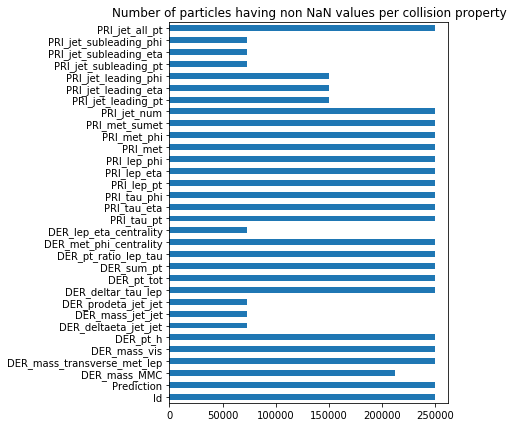

In [156]:
df.count().plot(kind='barh',title = 'Number of particles having non NaN values per collision property',figsize = (5,7))

(Description of result)

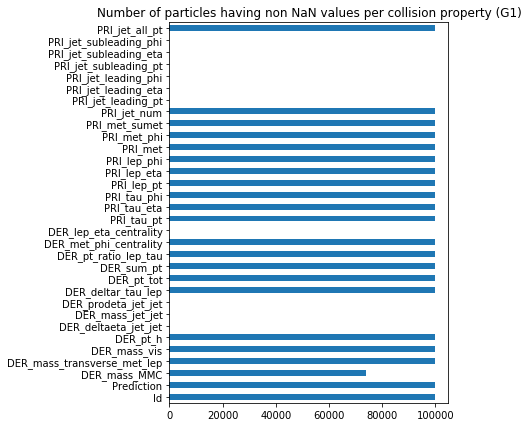

In [157]:
df[df.PRI_jet_num == 0].count().plot(kind='barh',title = 'Number of particles having numeric values per property (G0)',figsize = (5,7))

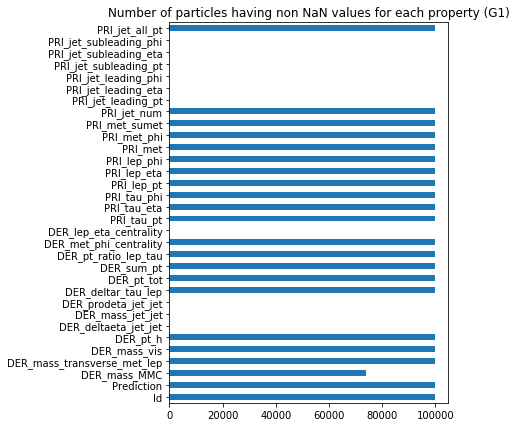

In [159]:
df[df.PRI_jet_num == 1].count().plot(kind='barh',title = 'Number of particles having numeric values per property (G1)',figsize = (5,7))

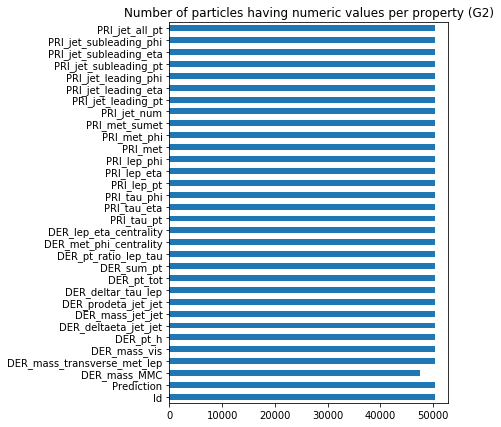

In [160]:
df[df.PRI_jet_num == 2].count().plot(kind='barh',title = 'Number of particles having numeric values per property (G2)',figsize = (5,7))

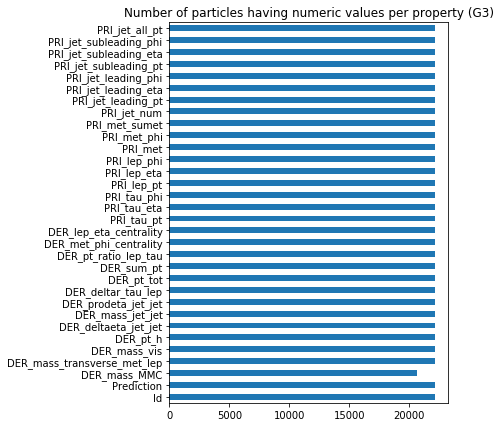

In [161]:
df[df.PRI_jet_num == 3].count().plot(kind='barh',title = 'Number of particles having numeric values per property (G3)',figsize = (5,7))

We notice that some particles do not have values for some columns, this tells us that there different categories of particles.
Lets set the goal of categorizing the particles 



To analyze more we look for the properties that are shared by all particles


In [39]:
props_in_all_particles = (df.count() == len(df))
props_in_common = props_in_all_particles[props_in_all_particles == True].index.drop(['Id','Prediction'])
props_in_common

Index(['DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h',
       'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'PRI_tau_pt',
       'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta',
       'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num',
       'PRI_jet_all_pt'],
      dtype='object')

We remove those columns first to get a better view of the rest of the properties 

We found the first category of particles : the ones that have all the properties in common
We name it category 1

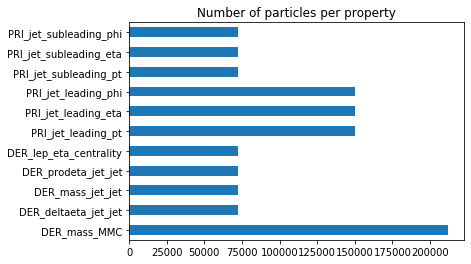

In [40]:
# reducing the dataset a to subset of properties that are not shared by all the particles
df_reduced = df.drop(columns = props_in_common)
df_reduced.count().drop(['Id','Prediction']).plot(kind = 'barh',figsize = (6,4), title='Number of particles per property')

## We try with Stochastic gradient descent 

In [ ]:
initial_w = np.zeros((tX.shape[1],1))
max_iters = 50
gamma = 0.6
#weights , loss = least_squares_SGD(y,tX,initial_w,max_iters,gamma)


#print(loss)

In [ ]:
d d

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)